In [2]:
# LOAD Abstracts

In [2]:
import pandas as pd
# === Save cleaned abstracts
abstracts = pd.read_parquet("D:/NLP/tfidf_xgboost/cleaned_abstracts.parquet")
print(abstracts.head())

   paper_id                                           abstract  \
0         0  The development of an automated system for the...   
1         1  This paper proposes a novel hybrid forward alg...   
2         2  Modern CCD cameras are usually capable of a sp...   
3         3  This paper deals with the problem of fuzzy non...   
4         4  A number of neural networks can be formulated ...   

                                             cleaned  
0  development automated system quality assessmen...  
1  paper proposes novel hybrid forward algorithm ...  
2  modern ccd cameras usually capable spatial acc...  
3  paper deals problem fuzzy nonlinear model iden...  
4  number neural networks formulated linearinthep...  


In [3]:
#  LDA Topics from Cleaned Abstracts (Since it does not use semantic info)

In [2]:
import pandas as pd
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

docs = abstracts["cleaned"].tolist()

# 2. Tokenization
tokenized = [doc.split() for doc in docs]

# 3. Dictionary & Corpus
dictionary = corpora.Dictionary(tokenized)
# φίλτραρε πολύ σπάνιες/συχνές λέξεις αν θες:
dictionary.filter_extremes(no_below=5, no_above=0.9)
corpus = [dictionary.doc2bow(text) for text in tokenized]



In [3]:
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm

# 1. Ορισμός πειραμάτων με numeric alpha/eta
ks     = [10, 20, 30]
alphas = [1/k for k in ks]       # π.χ. ισοκατανομή: 1/num_topics
etas   = [0.01, 0.1]             # σταθερές τιμές
experiments = [(k, a, e) for k in ks for a in alphas for e in etas]

results = []

# 2. Loop με tqdm και multicore LDA
for k, alpha, eta in tqdm(experiments, desc="LDA grid-search"):
    lda = LdaMulticore(
        corpus=corpus,
        num_topics=k,
        id2word=dictionary,
        passes=10,         # πόσες full passes πάνω στο corpus
        chunksize=1000,    # μέγεθος batch λέξεων
        workers=7,         # αριθμός πυρήνων CPU
        alpha=alpha,       # numeric alpha
        eta=eta,           # numeric eta
        random_state=42
    )
    cm = CoherenceModel(
        model=lda,
        texts=tokenized,
        dictionary=dictionary,
        coherence='c_v'    # coherence metric
    )
    score = cm.get_coherence()
    results.append(((k, alpha, eta), score))

# 3. Βρες το καλύτερο σετ παραμέτρων
best_params, best_score = max(results, key=lambda x: x[1])
print(f"Best params → k={best_params[0]}, alpha={best_params[1]:.4f}, eta={best_params[2]:.2f}")
print(f"Best coherence (c_v): {best_score:.4f}")

# 4. Τέλος, εκπαιδεύεις το τελικό μοντέλο
best_k, best_alpha, best_eta = best_params
final_lda = LdaMulticore(
    corpus=corpus,
    num_topics=best_k,
    id2word=dictionary,
    passes=10,
    chunksize=1000,
    workers=4,
    alpha=best_alpha,
    eta=best_eta,
    random_state=42
)

# (Προαιρετικά) Εκτύπωσε τα top-words για κάθε topic:
for tid in range(best_k):
    terms = final_lda.show_topic(tid, topn=10)
    print(f"Topic {tid:02d}:", [w for w, _ in terms])


LDA grid-search: 100%|████████████████████████████████████████████████████████████████| 18/18 [48:47<00:00, 162.62s/it]


Best params → k=30, alpha=0.0333, eta=0.10
Best coherence (c_v): 0.4535
Topic 00: ['methods', 'algorithms', 'performance', 'however', 'many', 'approaches', 'existing', 'applications', 'recent', 'learning']
Topic 01: ['graph', 'network', 'networks', 'nodes', 'data', 'graphs', 'privacy', 'node', 'distributed', 'structure']
Topic 02: ['model', 'brain', 'may', 'study', 'behavior', 'different', 'cognitive', 'population', 'activity', 'response']
Topic 03: ['detection', 'recognition', 'face', 'images', 'proposed', 'facial', 'method', 'using', 'based', 'database']
Topic 04: ['parallel', 'processing', 'path', 'implementation', 'hardware', 'cells', 'cell', 'operators', 'moments', 'paths']
Topic 05: ['system', 'quality', 'systems', 'user', 'evaluation', 'performance', 'human', 'using', 'metrics', 'results']
Topic 06: ['knowledge', 'semantic', 'reasoning', 'logic', 'relations', 'semantics', 'representation', 'concepts', 'paper', 'information']
Topic 07: ['coding', 'image', 'visual', 'compression',

In [4]:
# Try 2 for better coherence score

In [7]:
from gensim.models import Phrases

# Εκπαίδευσε τα phrases
bigram = Phrases(tokenized, min_count=20, threshold=100)
trigram = Phrases(bigram[tokenized], min_count=10, threshold=50)

# Εφάρμοσέ τα
tokenized = [trigram[bigram[doc]] for doc in tokenized]

# Ξαναφτιάξε dictionary & corpus
dictionary = corpora.Dictionary(tokenized)
dictionary.filter_extremes(no_below=10, no_above=0.8)
corpus = [dictionary.doc2bow(doc) for doc in tokenized]


In [ ]:
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm

# 1. Ορισμός πειραμάτων με numeric alpha/eta
ks     = [40,50]
alphas = [1/k for k in ks]       # π.χ. ισοκατανομή: 1/num_topics
etas   = [0.1,]             # σταθερές τιμές
experiments = [(k, a, e) for k in ks for a in alphas for e in etas]

results = []

# 2. Loop με tqdm και multicore LDA
for k, alpha, eta in tqdm(experiments, desc="LDA grid-search"):
    lda = LdaMulticore(
        corpus=corpus,
        num_topics=best_k,
        id2word=dictionary,
        passes=20,           # από 20 → 30
        iterations=500,      # από default → 500
        chunksize=2000,       # μικρότερο batch
        workers=7,
        alpha=best_alpha,
        eta=best_eta,
        random_state=42
    )
    cm = CoherenceModel(
        model=lda,
        texts=tokenized,
        dictionary=dictionary,
        coherence='c_v'    # coherence metric
    )
    score = cm.get_coherence()
    print(k,alpha,eta,score)
    results.append(((k, alpha, eta), score))

# 3. Βρες το καλύτερο σετ παραμέτρων
best_params, best_score = max(results, key=lambda x: x[1])
print(f"Best params → k={best_params[0]}, alpha={best_params[1]:.4f}, eta={best_params[2]:.2f}")
print(f"Best coherence (c_v): {best_score:.4f}")

# 4. Τέλος, εκπαιδεύεις το τελικό μοντέλο
best_k, best_alpha, best_eta = best_params
final_lda = LdaMulticore(
    corpus=corpus,
    num_topics=best_k,
    id2word=dictionary,
    passes=30,           # από 20 → 30
    iterations=500,      # από default → 500
    chunksize=500,       # μικρότερο batch
    workers=7,
    alpha=best_alpha,
    eta=best_eta,
    random_state=42
)

# (Προαιρετικά) Εκτύπωσε τα top-words για κάθε topic:
for tid in range(best_k):
    terms = final_lda.show_topic(tid, topn=10)
    print(f"Topic {tid:02d}:", [w for w, _ in terms])


LDA grid-search: 100%|██████████████████████████████████████████████████████████████████| 4/4 [43:43<00:00, 655.88s/it]


Best params → k=50, alpha=0.0250, eta=0.01
Best coherence (c_v): 0.4303


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Compute document-topic distributions
doc_topics = np.array([
    [prob for _, prob in final_lda.get_document_topics(bow, minimum_probability=0)]
    for bow in corpus
])
# Determine dominant topic per document
dominant_topics = np.argmax(doc_topics, axis=1)

# Reduce to 2D via PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(doc_topics)

# Plot scatter by dominant topic
plt.figure(figsize=(10, 7))
for t in range(final_lda.num_topics):
    mask = dominant_topics == t
    plt.scatter(coords[mask, 0], coords[mask, 1], label=f'Topic {t}', s=10)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title('2D Visualization of Document-Topic Distributions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()


In [ ]:
# Top2Vec

In [3]:
# pip install top2vec
from top2vec import Top2Vec

docs = abstracts["abstract"].tolist()
model = Top2Vec(documents=docs, 
                speed="deep-learn",      # ή "deep-learn" για καλύτερα embeddings
                use_corpus_file=False)

# number of topics
print("Num topics:", model.get_num_topics())




2025-05-16 14:17:14,825 - top2vec - INFO - Pre-processing documents for training
D:\NLP\gnn_env\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-05-16 14:18:08,735 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
2025-05-16 14:18:36,166 - top2vec - INFO - Creating joint document/word embedding
2025-05-16 14:22:36,408 - top2vec - INFO - Creating lower dimension embedding of documents
D:\NLP\gnn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-16 14:24:15,935 - top2vec - INFO - Finding dense areas of documents
D:\NLP\gnn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\NLP\gnn_env\lib\site-packages\sk

Num topics: 736


In [4]:
# Πόσα topics βρήκε
num_topics = model.get_num_topics()

# Παίρνουμε όλα τα topics, τα scores και τα sizes
words_per_topic, word_scores, topic_sizes = model.get_topics()

# Εκτύπωση first 10 λέξεων για κάθε topic
for topic_num in range(num_topics):
    top_words = words_per_topic[topic_num][:10]
    print(f"Topic {topic_num:02d}:", top_words)

Topic 00: ['translations' 'translators' 'translator' 'corpus' 'translational'
 'translating' 'treebanks' 'corpora' 'treebank' 'transliteration']
Topic 01: ['tracking' 'tracker' 'tracklets' 'trackers' 'track' 'tracklet'
 'supervised' 'tracked' 'footage' 'detections']
Topic 02: ['videos' 'actions' 'activities' 'footage' 'recognition' 'activity'
 'action' 'convnets' 'recognizing' 'kinect']
Topic 03: ['parsers' 'treebanks' 'parsing' 'treebank' 'parser' 'parse' 'parses'
 'parsed' 'grammars' 'corpus']
Topic 04: ['backpropagation' 'controllability' 'controller' 'adaptive' 'controllers'
 'controllable' 'controls' 'lyapunov' 'control' 'controlling']
Topic 05: ['reinforcement' 'learns' 'learning' 'learnt' 'planning' 'learnable'
 'adaptively' 'backpropagation' 'adaptive' 'ai']
Topic 06: ['mapreduce' 'dataflow' 'databases' 'dbmss' 'dbs' 'dbms' 'materialized'
 'db' 'concurrency' 'dbm']
Topic 07: ['saliency' 'salient' 'attention' 'attentions' 'salience' 'superpixels'
 'attentional' 'supervoxels' 'vi

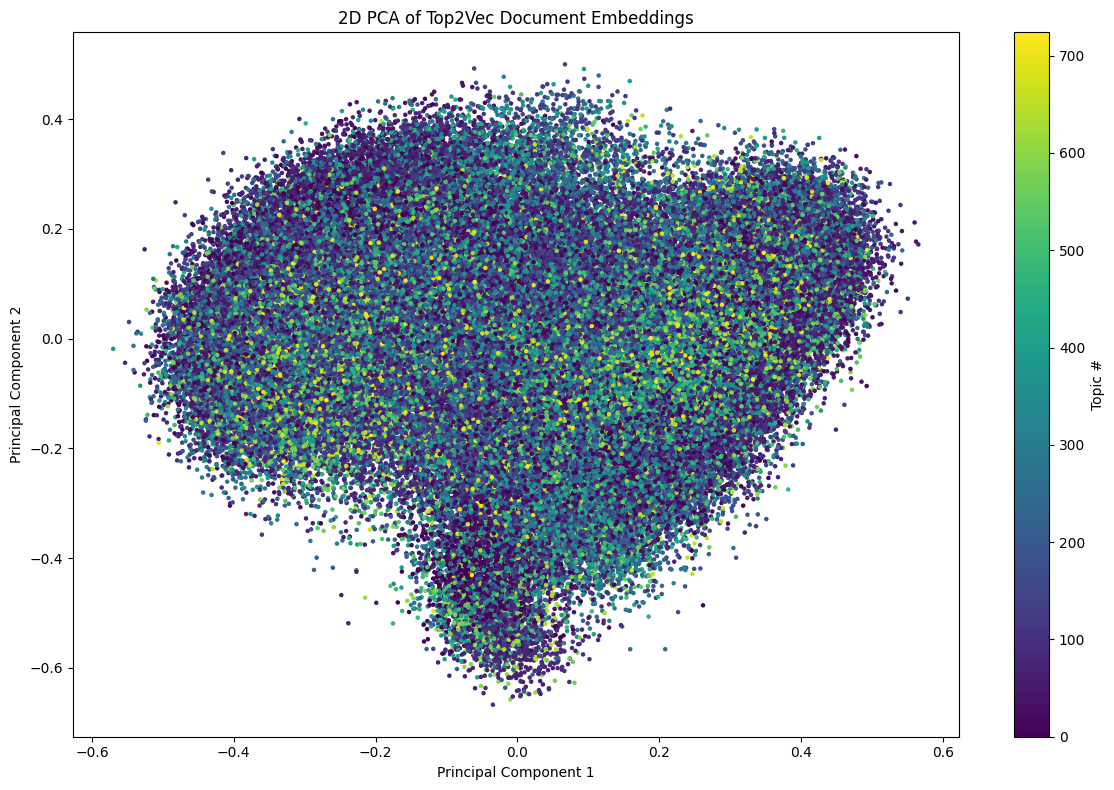

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1) Πάρε τα document vectors απευθείας από το μοντέλο
#    (όπου model είναι το ήδη εκπαιδευμένο Top2Vec αντικείμενό σου)
embeddings = model.document_vectors  
# :contentReference[oaicite:0]{index=0}

# 2) Πάρε για κάθε doc το κυρίαρχο topic (num_topics=1)
doc_ids = list(range(len(docs)))  
topic_nums, topic_scores, topics_words, word_scores = model.get_documents_topics(
    doc_ids, num_topics=1
)
dominant = topic_nums.flatten()  
# :contentReference[oaicite:1]{index=1}

# 3) Μείωσε σε 2 διαστάσεις με PCA
coords = PCA(n_components=2, random_state=42).fit_transform(embeddings)

# 4) Σχεδίασε scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    coords[:, 0], coords[:, 1],
    c=dominant,      # χρώμα με βάση το topic index
    s=5              # μέγεθος κουκκίδας
)
plt.colorbar(scatter, label="Topic #")
plt.title("2D PCA of Top2Vec Document Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()


D:\NLP\gnn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\NLP\gnn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
D:\NLP\gnn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\NLP\gnn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


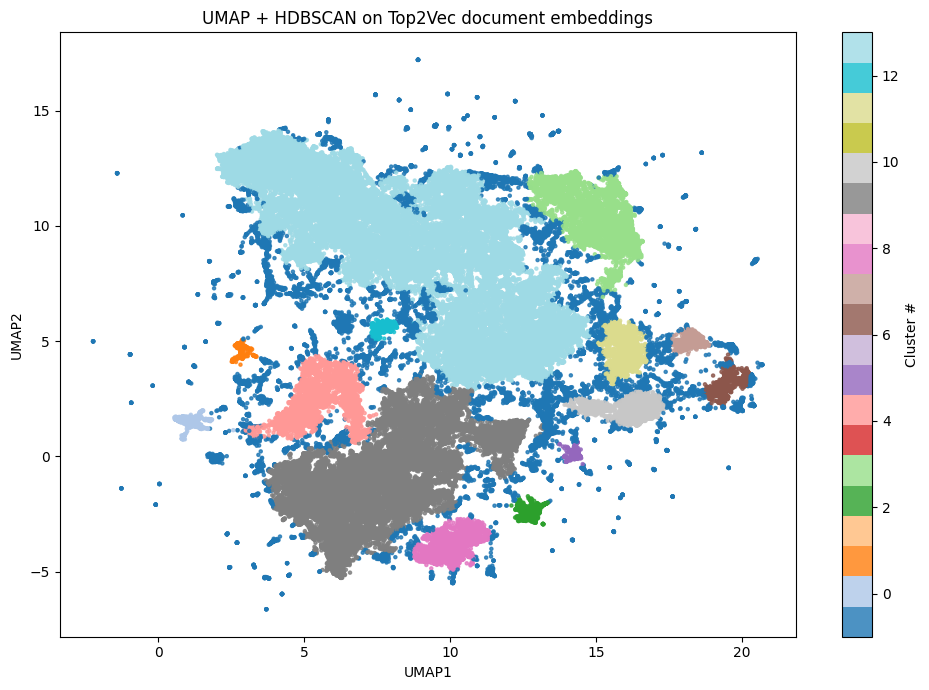

In [18]:
from umap import UMAP
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt

# 1) Document embeddings
embs = model.document_vectors  # σχήμα: (n_docs, emb_dim)

# 2) UMAP σε 2D
umap_embs = UMAP(
    n_neighbors=5,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
).fit_transform(embs)

# 3) HDBSCAN clustering
clusterer = HDBSCAN(
    min_cluster_size=500,       # ρύθμισε ώστε να έχεις ~50 clusters
    metric="euclidean",
    cluster_selection_method="eom"
)
labels = clusterer.fit_predict(umap_embs)  # -1 = θόρυβος

# 4) Scatter plot
plt.figure(figsize=(10,7))
sc = plt.scatter(
    umap_embs[:,0], umap_embs[:,1],
    c=labels,
    cmap="tab20",
    s=5,
    alpha=0.8
)
plt.colorbar(sc, label="Cluster #")
plt.title("UMAP + HDBSCAN on Top2Vec document embeddings")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()


In [ ]:
#[I 2025-05-16 01:31:19,895] Trial 15 finished with value: 0.6046906472610597 and parameters: {'n_neighbors': 39, 'min_dist': 0.4515434035502789, 'min_cluster_size': 109}. Best is trial 15 with value: 0.6046906472610597.

In [19]:
import numpy as np
unique, counts = np.unique(labels, return_counts=True)
print(sorted(zip(unique, counts), key=lambda x: -x[1])[:10])


[(13, 52514), (9, 32015), (-1, 17862), (3, 7922), (4, 5750), (8, 3952), (10, 2817), (11, 2634), (6, 1250), (2, 1064)]


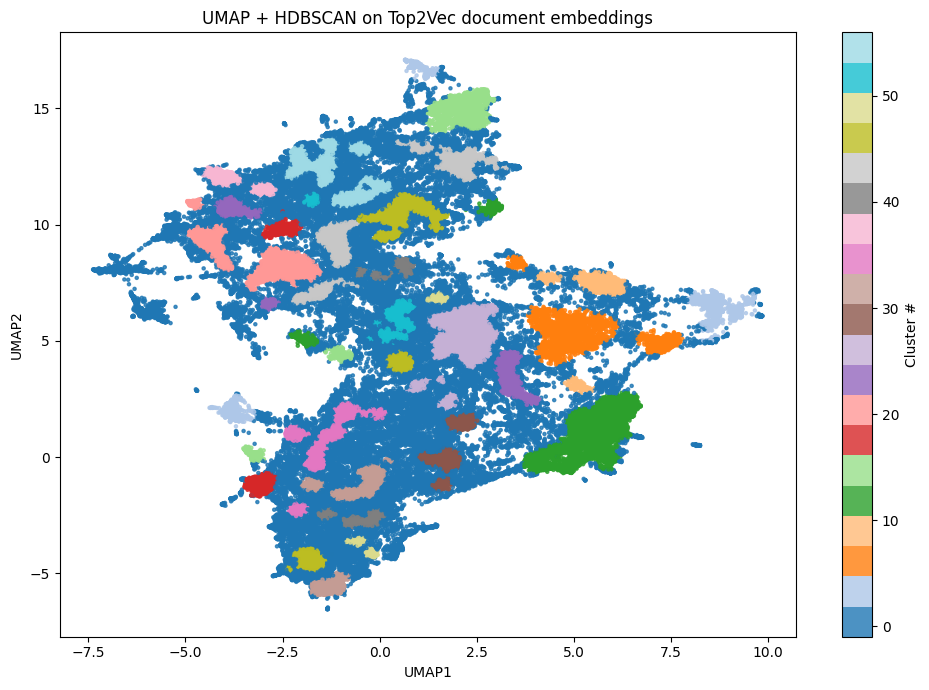

In [55]:
from umap import UMAP
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt

# 1) Document embeddings
embs = model.document_vectors  # σχήμα: (n_docs, emb_dim)

# 2) UMAP σε 2D
umap_embs = UMAP(
    n_neighbors=9,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
).fit_transform(embs)

# 3) HDBSCAN clustering
clusterer = HDBSCAN(
    min_cluster_size=300,       # ρύθμισε ώστε να έχεις ~50 clusters
    metric="euclidean",
    cluster_selection_method="eom"
)
labels = clusterer.fit_predict(umap_embs)  # -1 = θόρυβος

# 4) Scatter plot
plt.figure(figsize=(10,7))
sc = plt.scatter(
    umap_embs[:,0], umap_embs[:,1],
    c=labels,
    cmap="tab20",
    s=5,
    alpha=0.8
)
plt.colorbar(sc, label="Cluster #")
plt.title("UMAP + HDBSCAN on Top2Vec document embeddings")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()


In [ ]:
#[I 2025-05-16 01:31:19,895] Trial 15 finished with value: 0.6046906472610597 and parameters:
#{'n_neighbors': 39, 'min_dist': 0.4515434035502789, 'min_cluster_size': 109}.
# Best is trial 15 with value: 0.6046906472610597.

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt

# 1) Document embeddings
embs = model.document_vectors  # σχήμα: (n_docs, emb_dim)

# 2) UMAP σε 2D
umap_embs = UMAP(
    n_neighbors=21,
    min_dist=0.15,
    n_components=2,
    metric="cosine",
    random_state=42
).fit_transform(embs)

# 3) HDBSCAN clustering
clusterer = HDBSCAN(
    min_cluster_size=300,       # ρύθμισε ώστε να έχεις ~50 clusters
    metric="euclidean",
    cluster_selection_method="eom"
)
labels = clusterer.fit_predict(umap_embs)  # -1 = θόρυβος

# 4) Scatter plot
plt.figure(figsize=(10,7))
sc = plt.scatter(
    umap_embs[:,0], umap_embs[:,1],
    c=labels,
    cmap="tab20",
    s=5,
    alpha=0.8
)
plt.colorbar(sc, label="Cluster #")
plt.title("UMAP + HDBSCAN on Top2Vec document embeddings")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()


D:\NLP\gnn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\NLP\gnn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_n=9, md=0.1) + HDBSCAN(mcs=100) -> coherence=0.6674


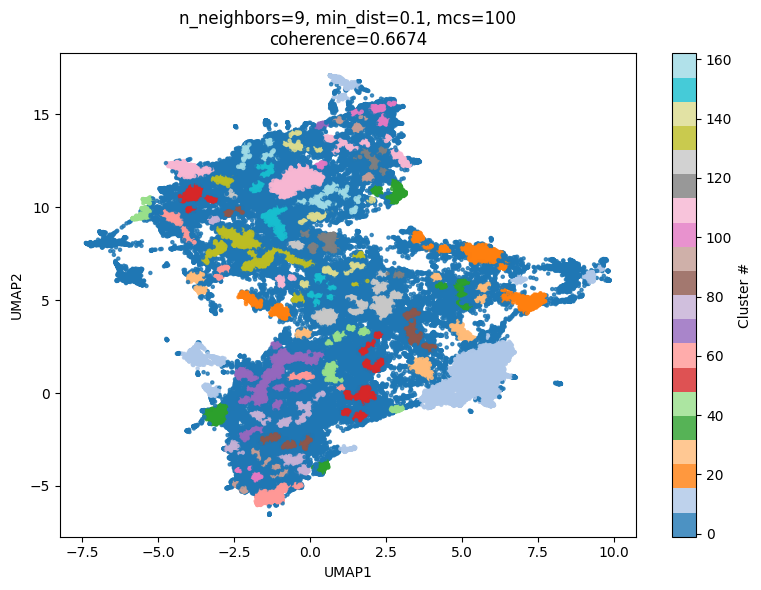

UMAP(n_n=9, md=0.1) + HDBSCAN(mcs=150) -> coherence=0.6525


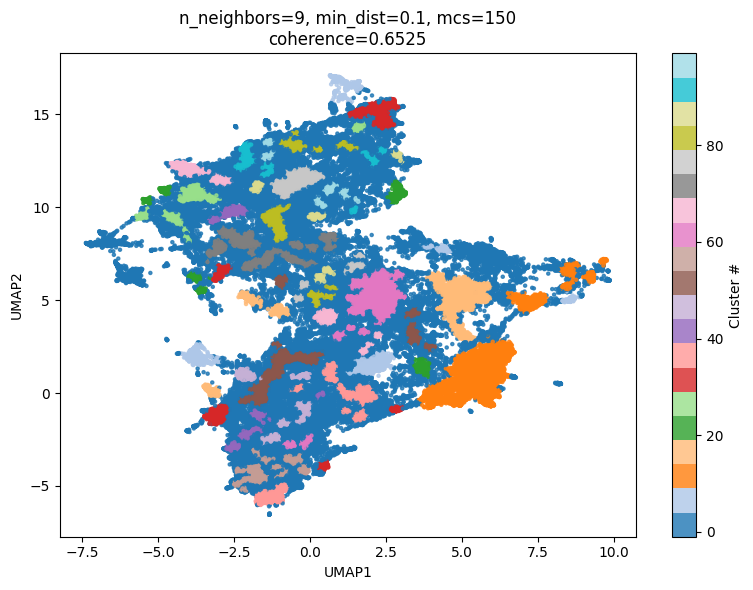

UMAP(n_n=9, md=0.1) + HDBSCAN(mcs=250) -> coherence=0.6630


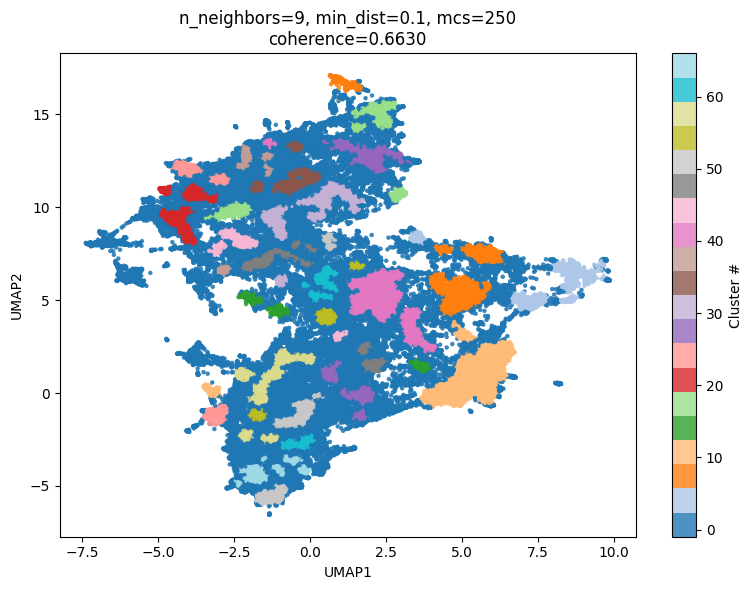

UMAP(n_n=9, md=0.1) + HDBSCAN(mcs=300) -> coherence=0.6623


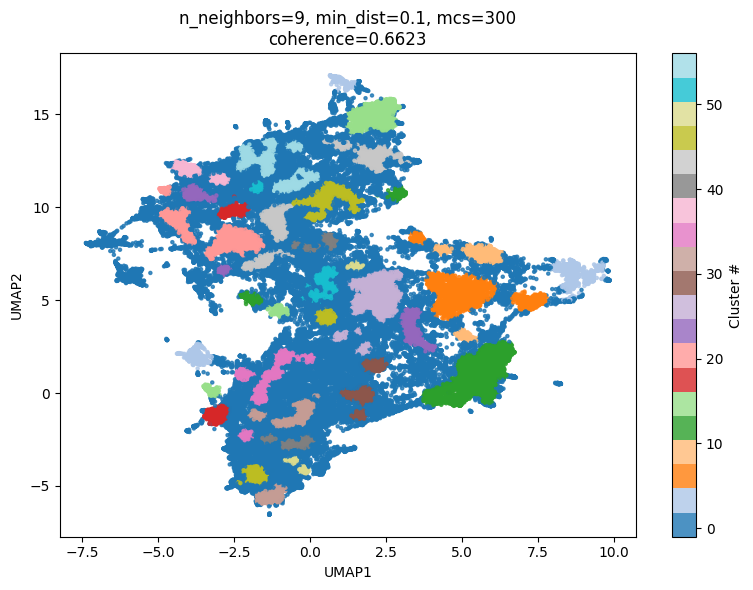

UMAP(n_n=9, md=0.1) + HDBSCAN(mcs=350) -> coherence=0.6614


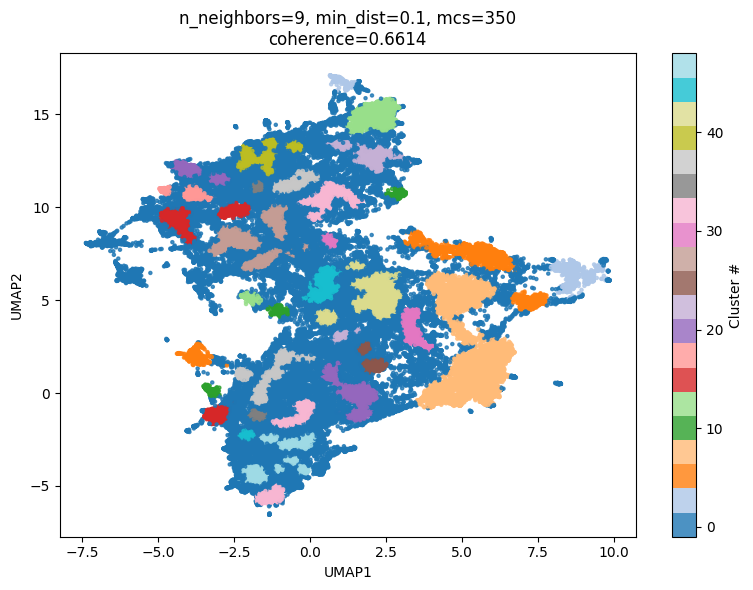

UMAP(n_n=9, md=0.1) + HDBSCAN(mcs=400) -> coherence=0.6691


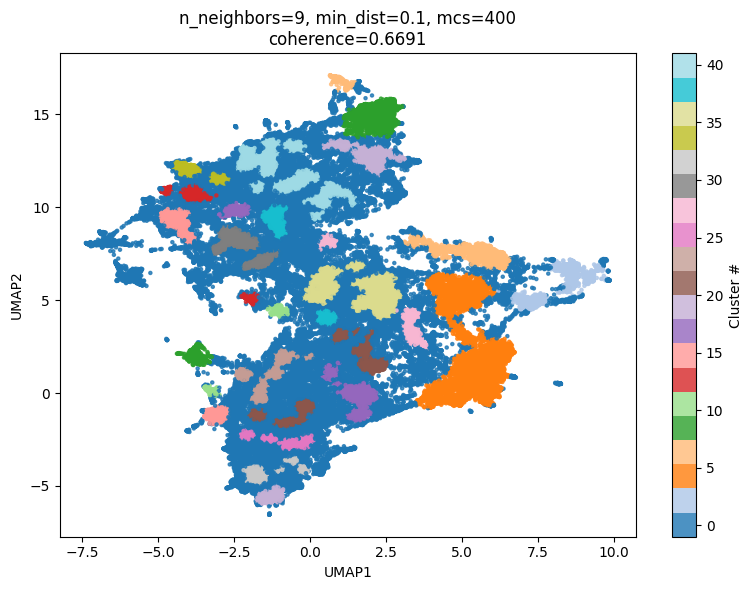

UMAP(n_n=9, md=0.1) + HDBSCAN(mcs=500) -> coherence=0.6442


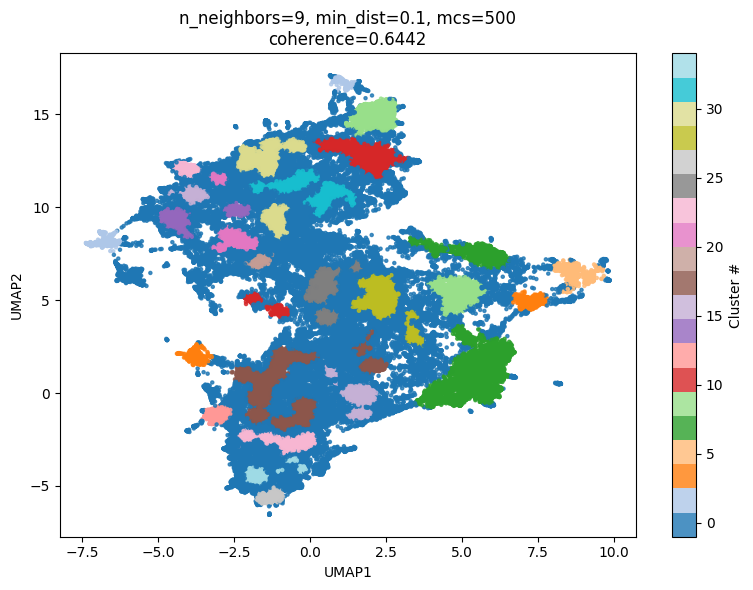

UMAP(n_n=9, md=0.15) + HDBSCAN(mcs=100) -> coherence=0.6508


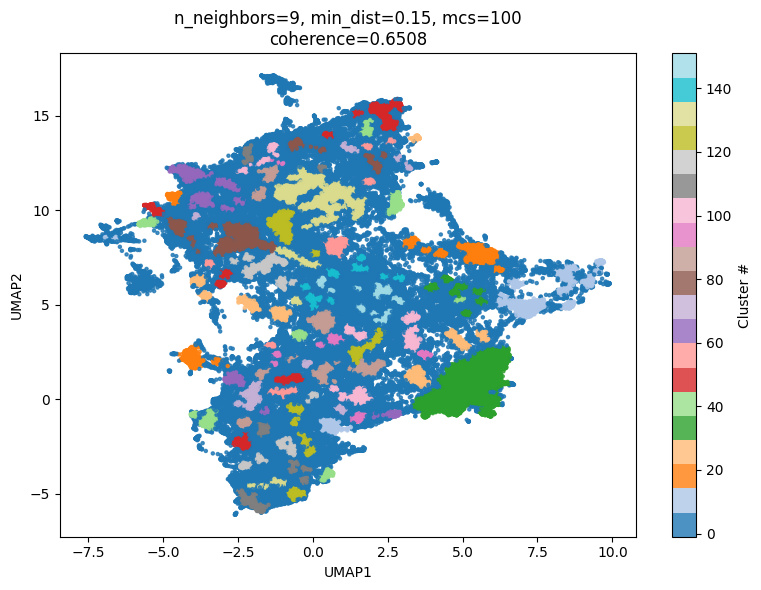

UMAP(n_n=9, md=0.15) + HDBSCAN(mcs=150) -> coherence=0.6559


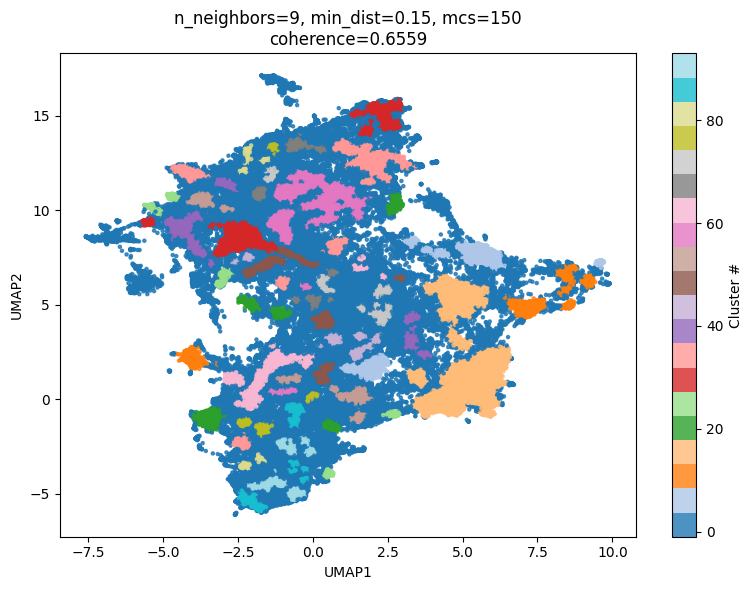

UMAP(n_n=9, md=0.15) + HDBSCAN(mcs=250) -> coherence=0.6649


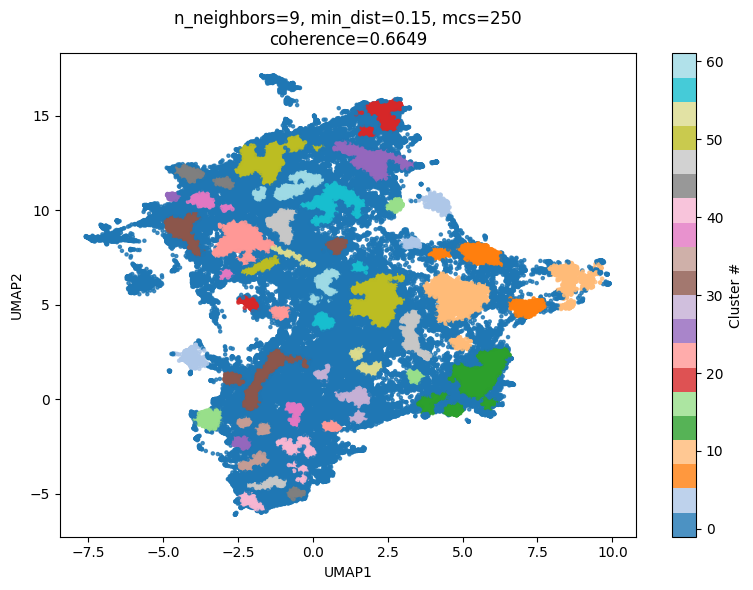

UMAP(n_n=9, md=0.15) + HDBSCAN(mcs=300) -> coherence=0.6499


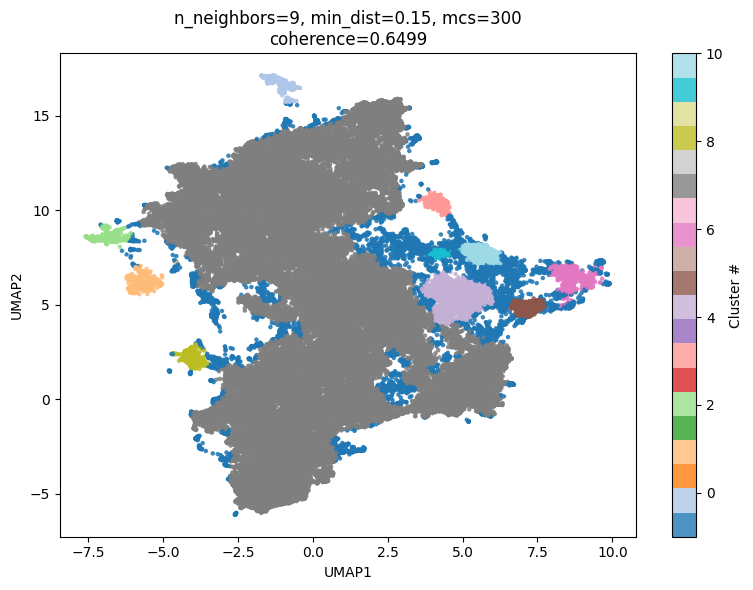

UMAP(n_n=9, md=0.15) + HDBSCAN(mcs=350) -> coherence=0.6563


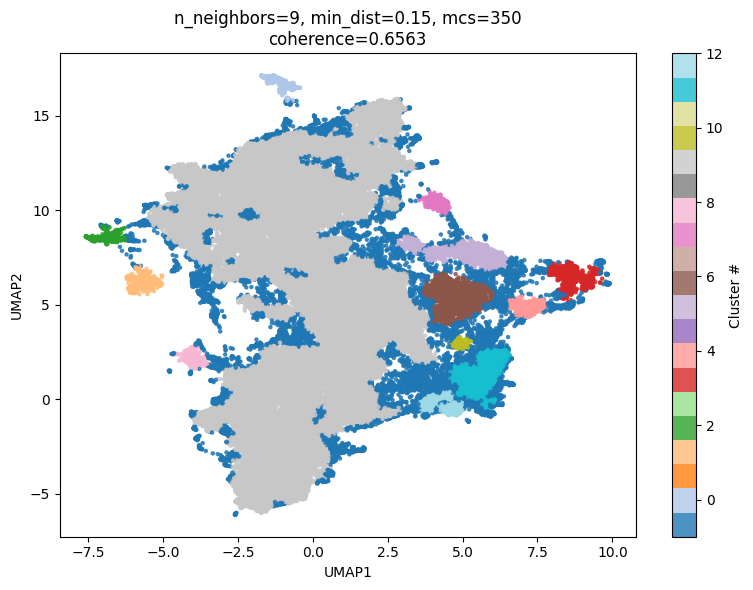

UMAP(n_n=9, md=0.15) + HDBSCAN(mcs=400) -> coherence=0.5610


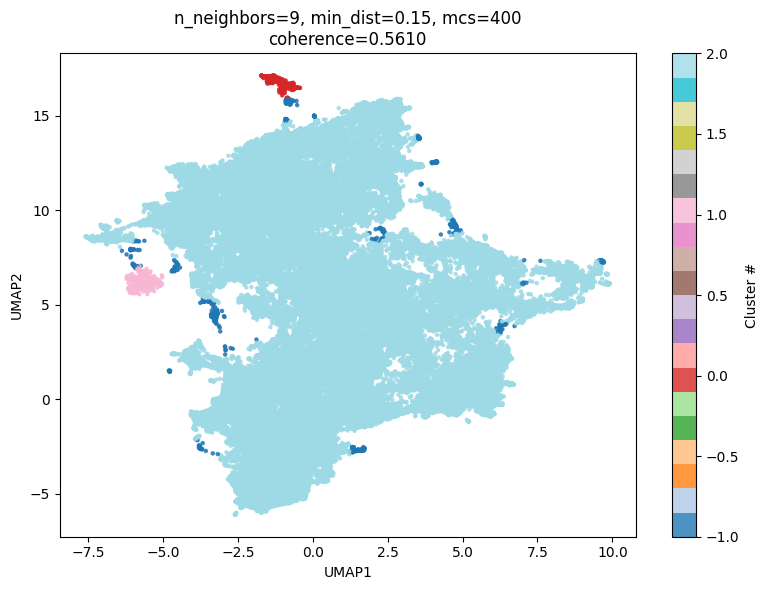

UMAP(n_n=9, md=0.15) + HDBSCAN(mcs=500) -> coherence=0.5610


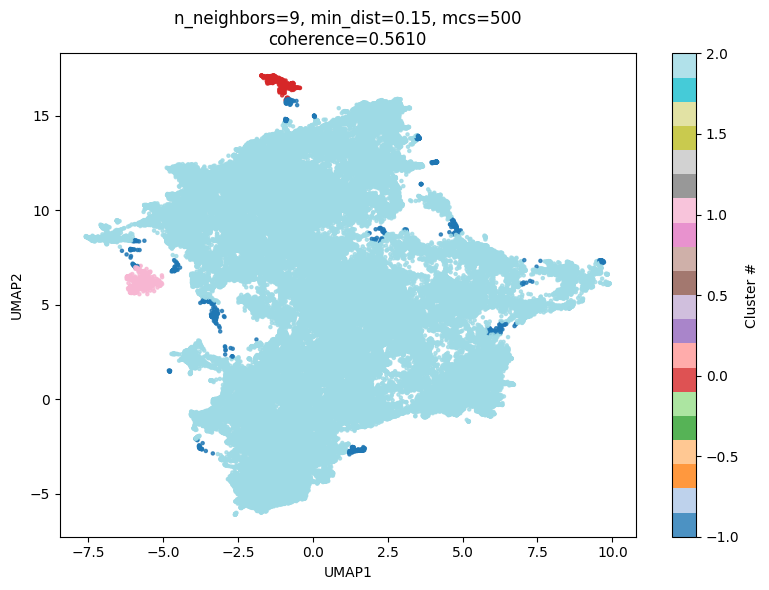

UMAP(n_n=9, md=0.2) + HDBSCAN(mcs=100) -> coherence=0.6629


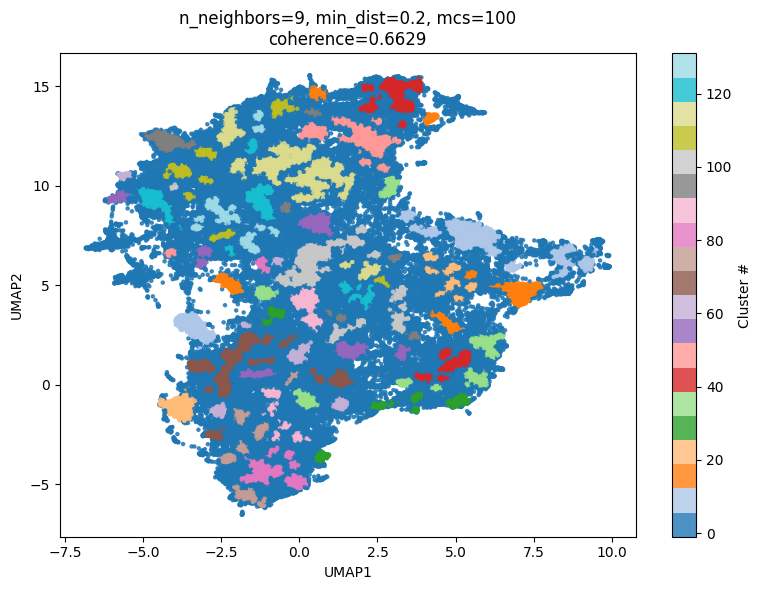

UMAP(n_n=9, md=0.2) + HDBSCAN(mcs=150) -> coherence=0.6543


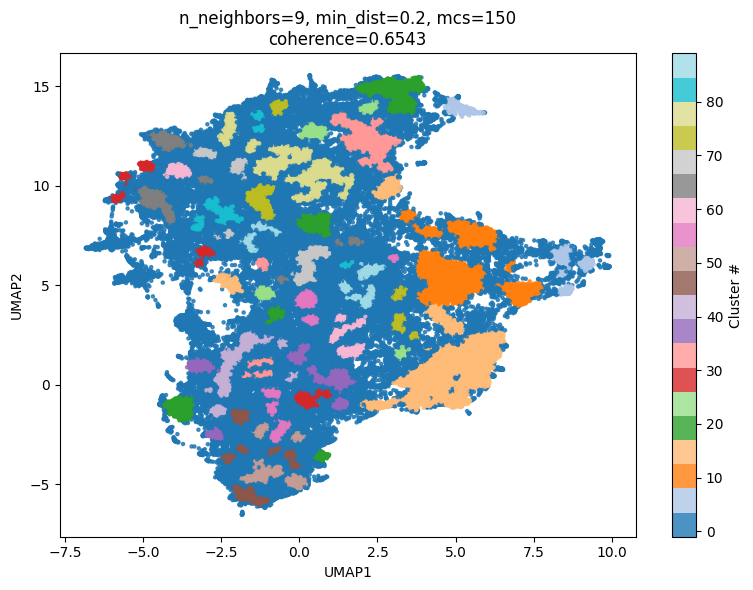

UMAP(n_n=9, md=0.2) + HDBSCAN(mcs=250) -> coherence=0.6560


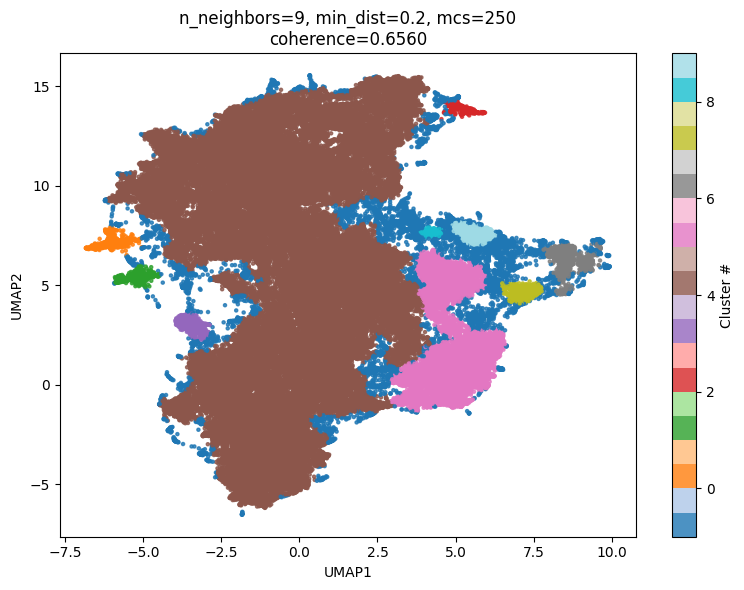

UMAP(n_n=9, md=0.2) + HDBSCAN(mcs=300) -> coherence=0.6659


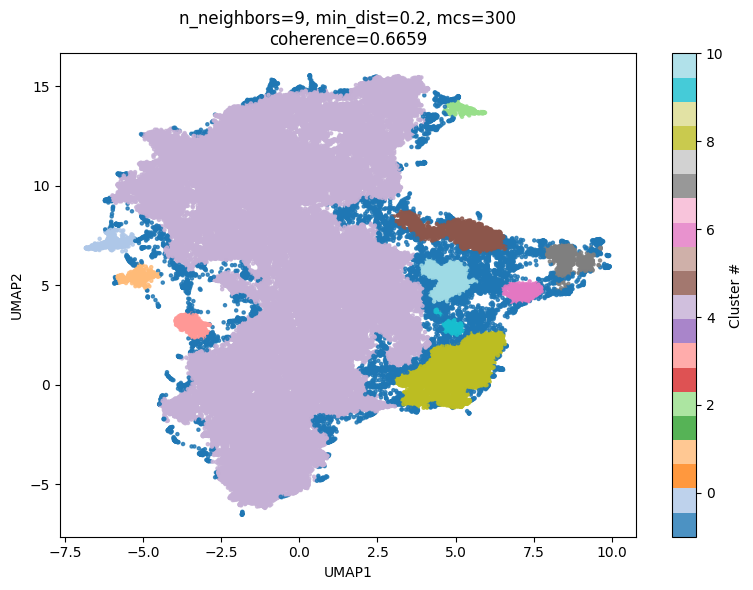

UMAP(n_n=9, md=0.2) + HDBSCAN(mcs=350) -> coherence=0.6494


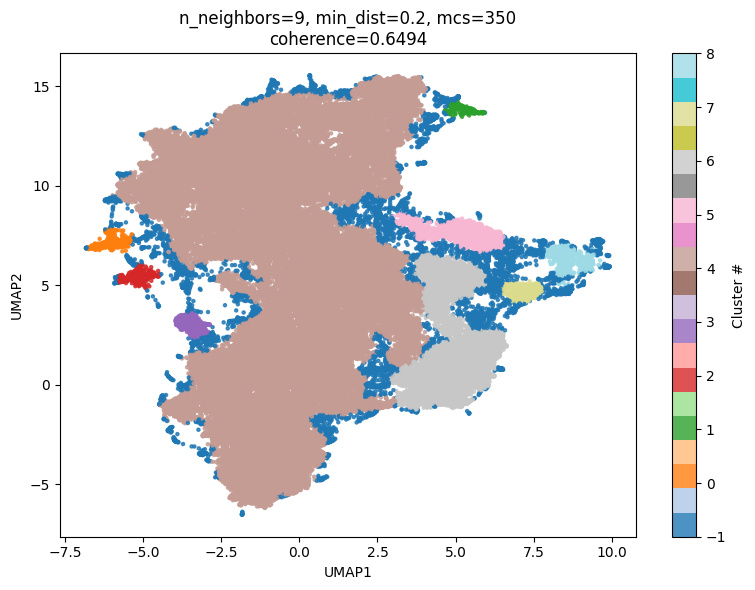

UMAP(n_n=9, md=0.2) + HDBSCAN(mcs=400) -> coherence=0.6483


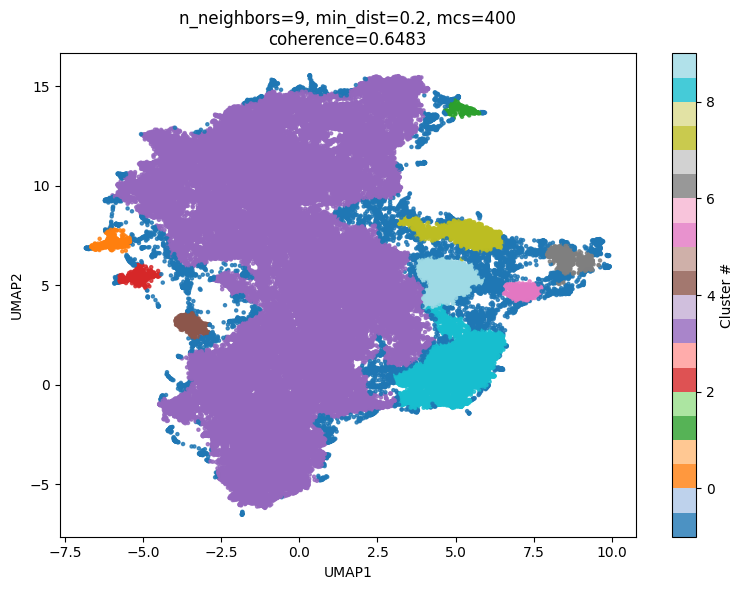

UMAP(n_n=9, md=0.2) + HDBSCAN(mcs=500) -> coherence=0.6458


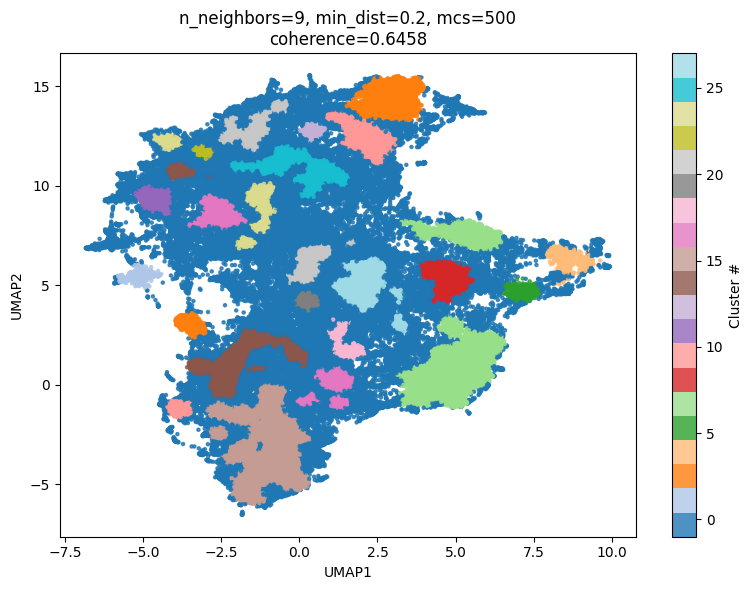

UMAP(n_n=11, md=0.1) + HDBSCAN(mcs=100) -> coherence=0.6662


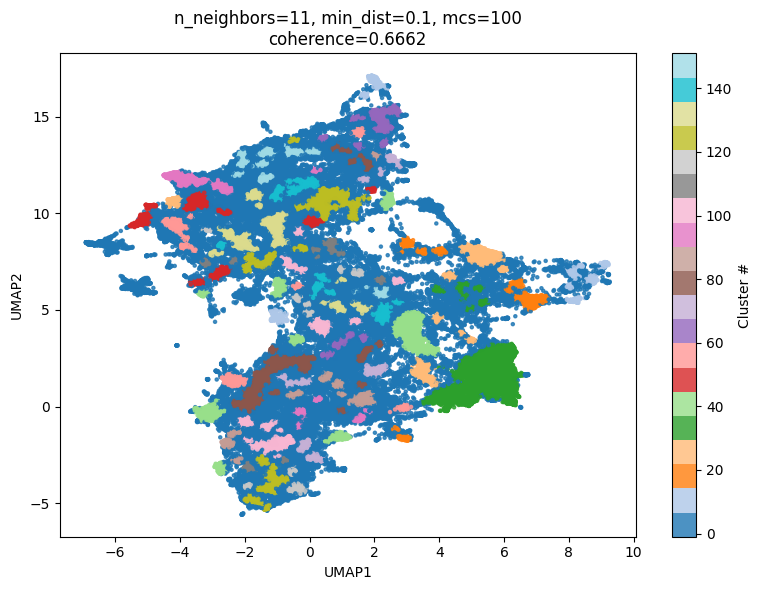

UMAP(n_n=11, md=0.1) + HDBSCAN(mcs=150) -> coherence=0.6594


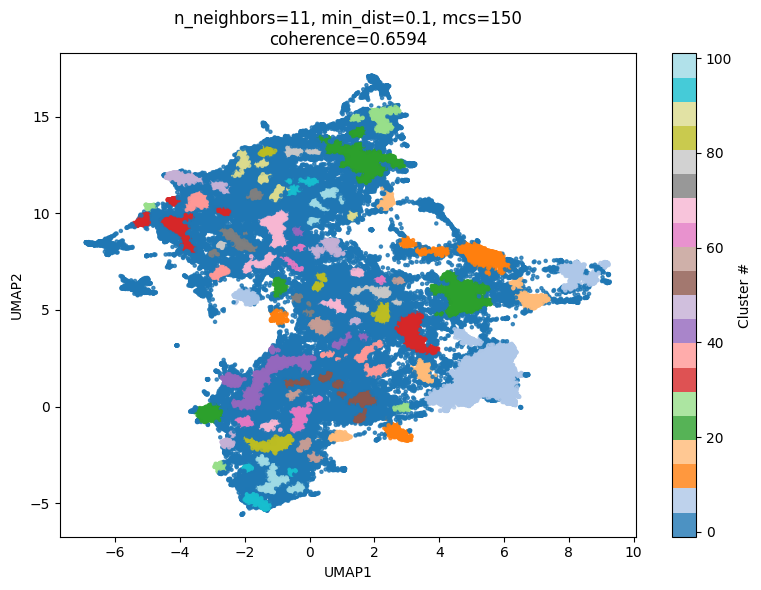

UMAP(n_n=11, md=0.1) + HDBSCAN(mcs=250) -> coherence=0.6674


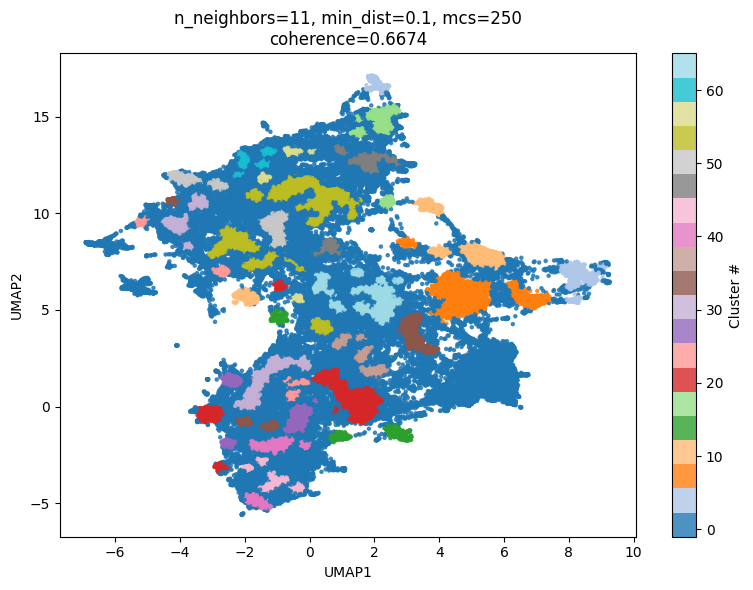

UMAP(n_n=11, md=0.1) + HDBSCAN(mcs=300) -> coherence=0.6670


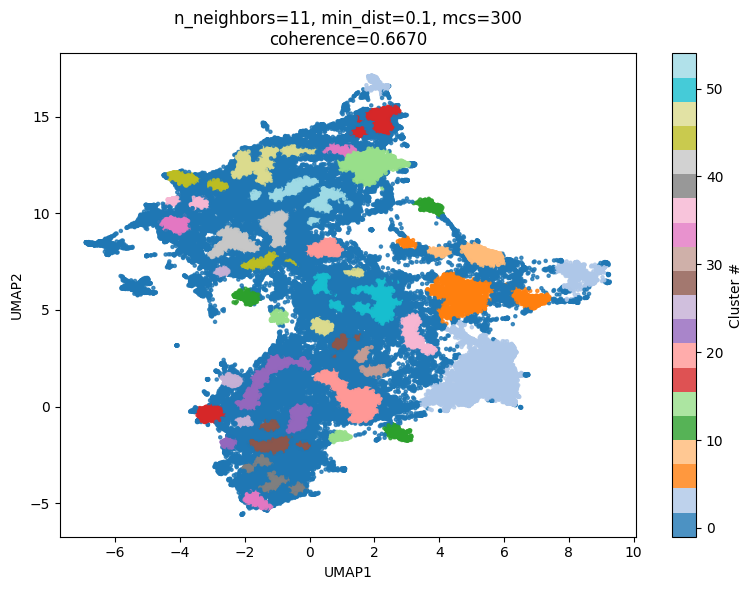

UMAP(n_n=11, md=0.1) + HDBSCAN(mcs=350) -> coherence=0.6719


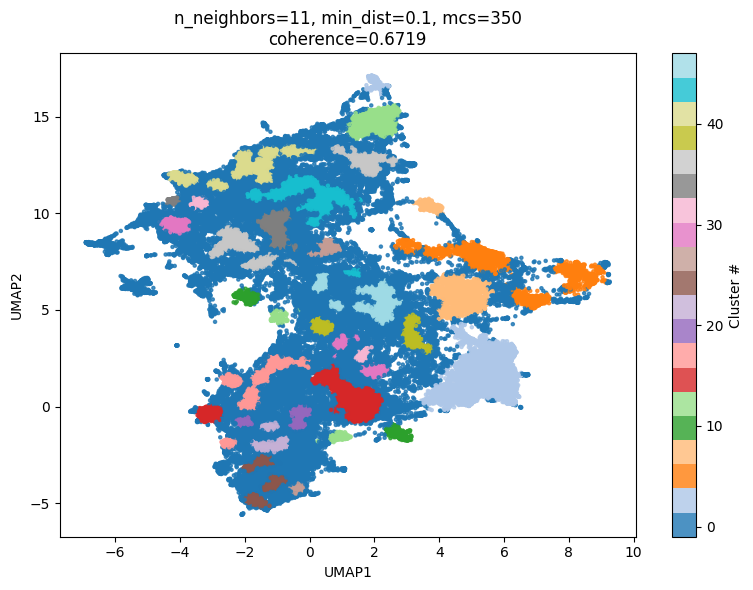

UMAP(n_n=11, md=0.1) + HDBSCAN(mcs=400) -> coherence=0.5047


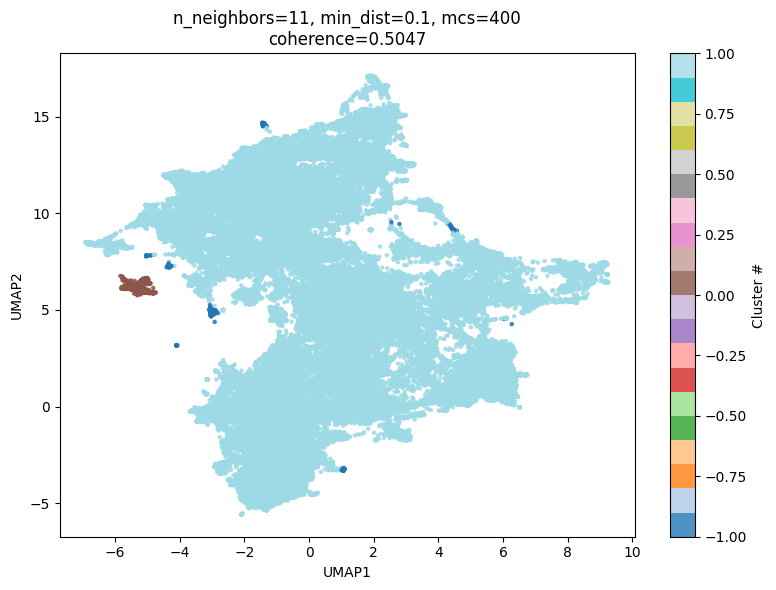

UMAP(n_n=11, md=0.1) + HDBSCAN(mcs=500) -> coherence=0.6389


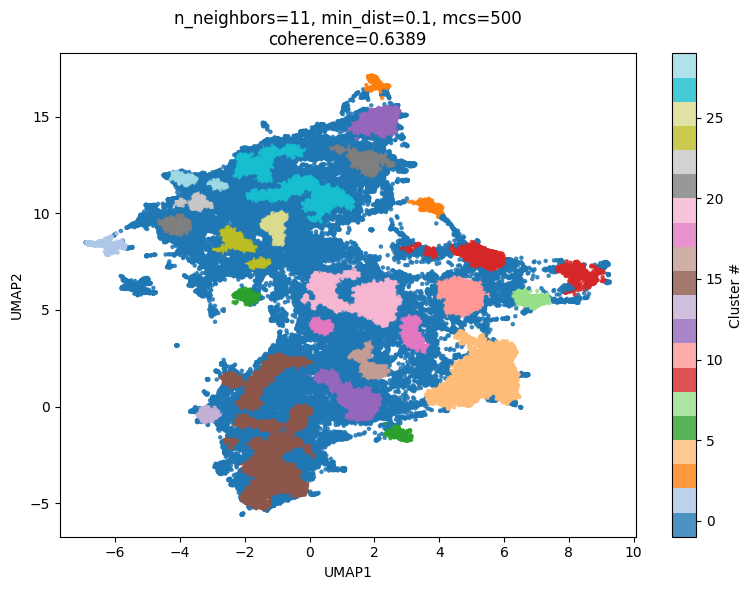

UMAP(n_n=11, md=0.15) + HDBSCAN(mcs=100) -> coherence=0.6612


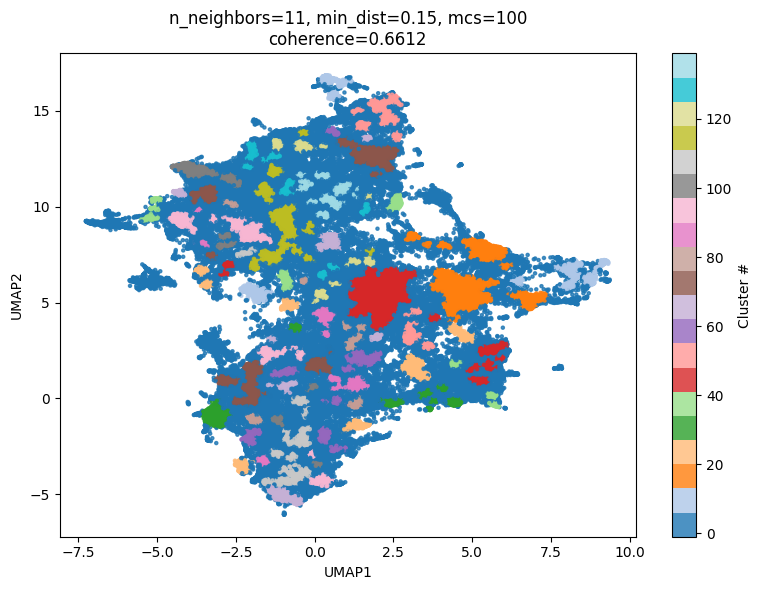

UMAP(n_n=11, md=0.15) + HDBSCAN(mcs=150) -> coherence=0.5047


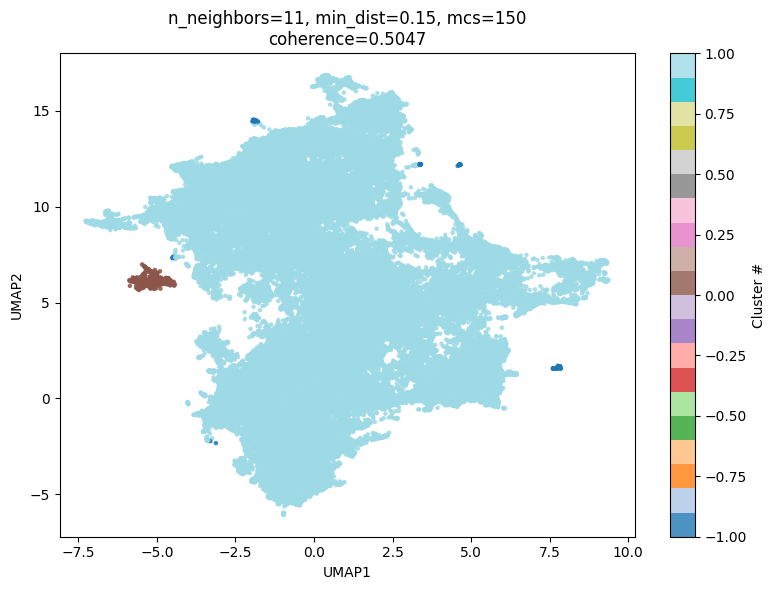

UMAP(n_n=11, md=0.15) + HDBSCAN(mcs=250) -> coherence=0.5788


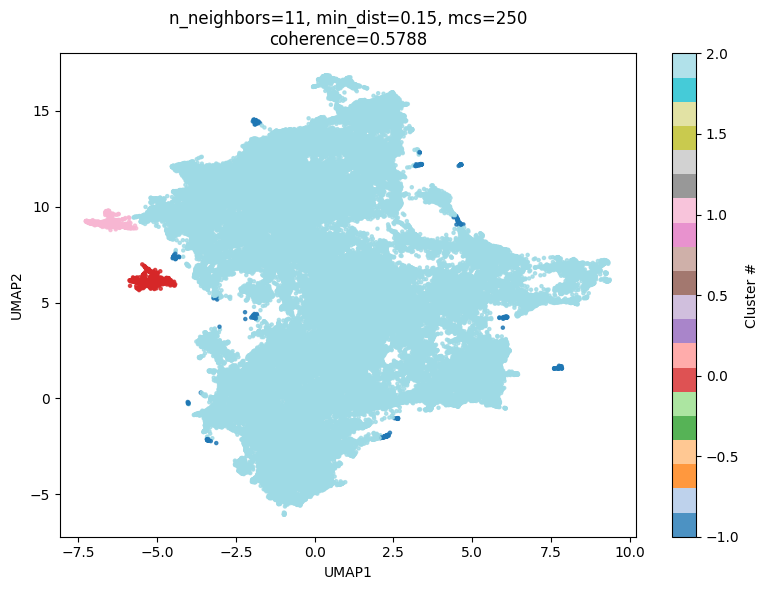

UMAP(n_n=11, md=0.15) + HDBSCAN(mcs=300) -> coherence=0.6738


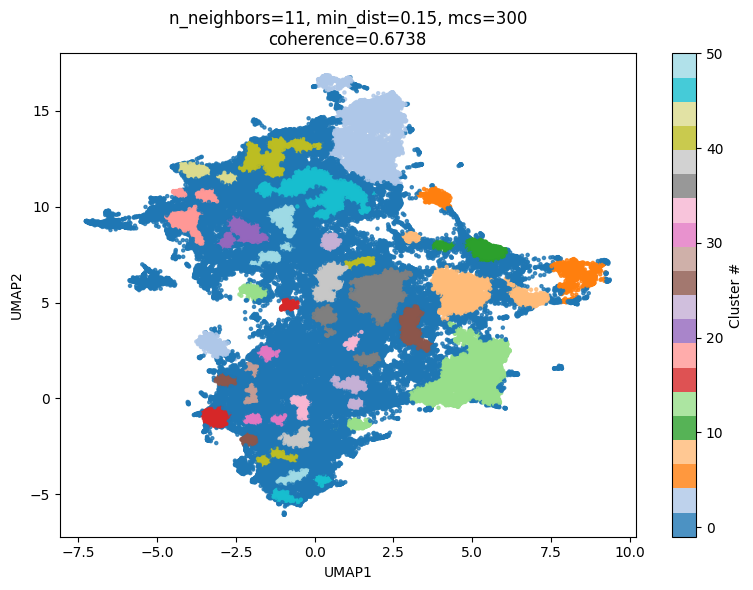

UMAP(n_n=11, md=0.15) + HDBSCAN(mcs=350) -> coherence=0.6600


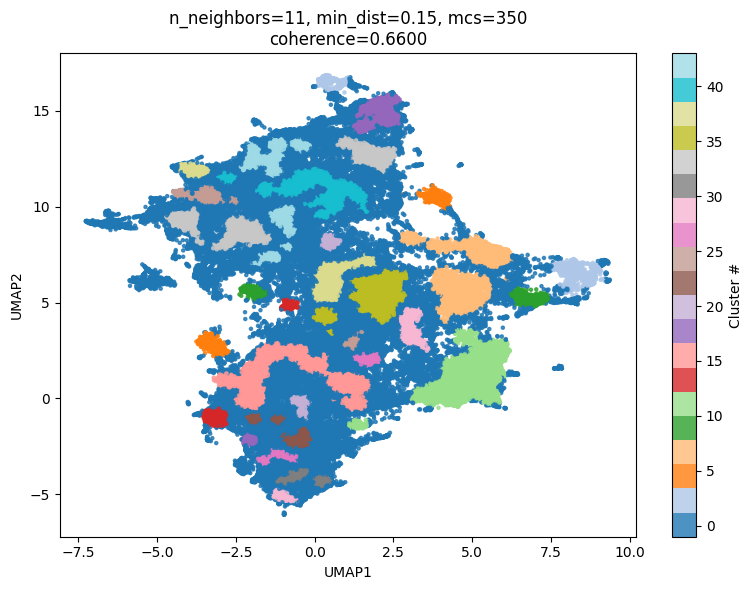

UMAP(n_n=11, md=0.15) + HDBSCAN(mcs=400) -> coherence=0.6444


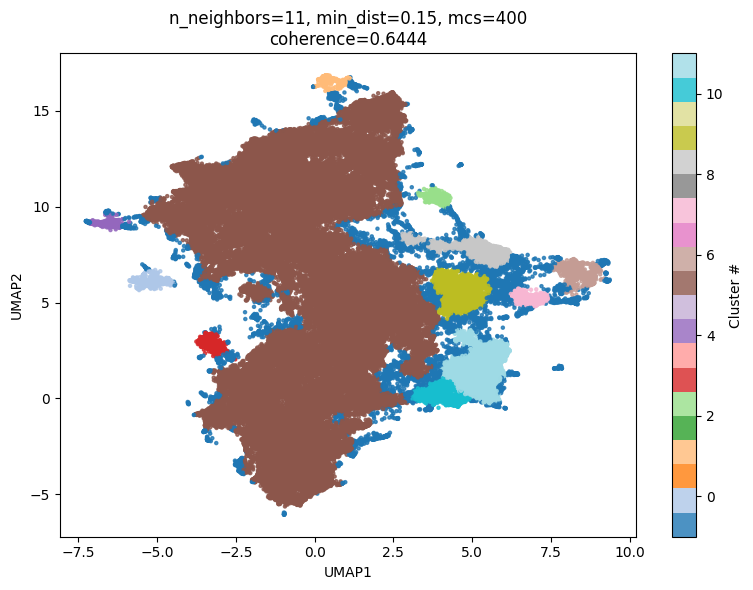

UMAP(n_n=11, md=0.15) + HDBSCAN(mcs=500) -> coherence=0.5477


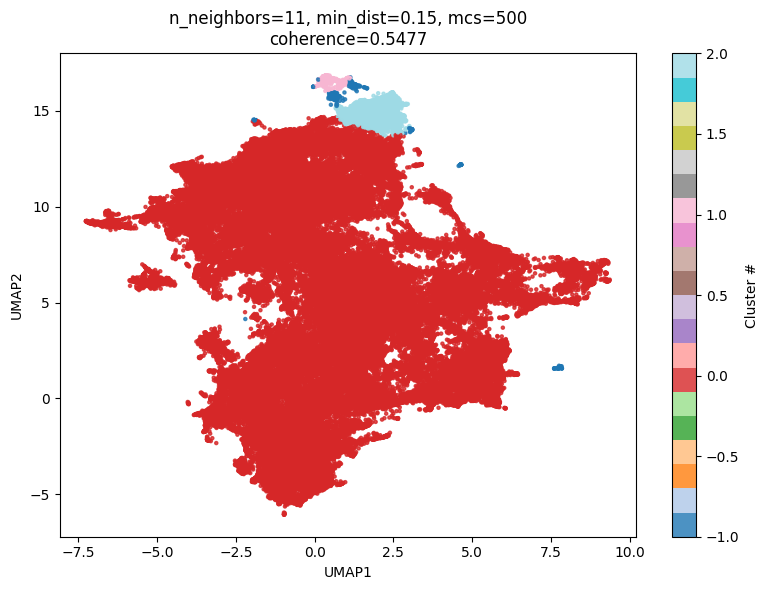

UMAP(n_n=11, md=0.2) + HDBSCAN(mcs=100) -> coherence=0.6644


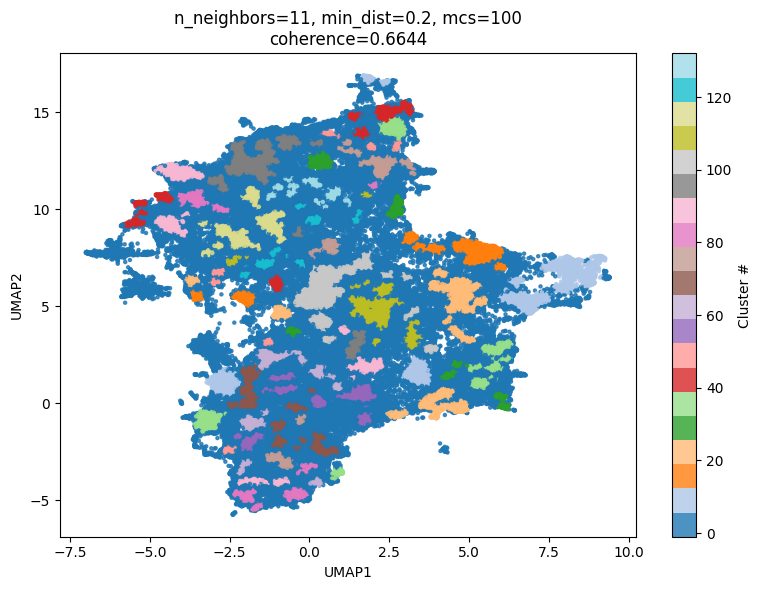

UMAP(n_n=11, md=0.2) + HDBSCAN(mcs=150) -> coherence=0.6633


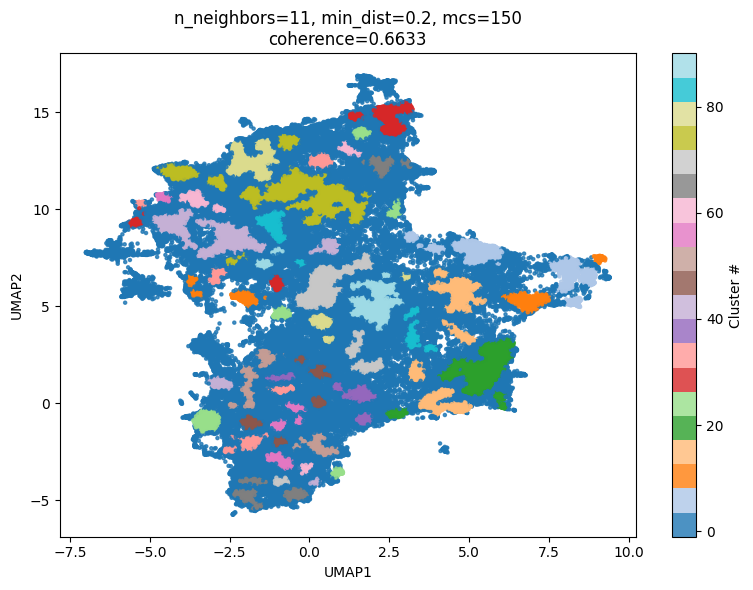

In [ ]:
# Fine Tune
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

# 0) Prepare cleaned texts, tokenized, dictionary for coherence
# abstracts is your DataFrame with columns "abstract" (raw) and "cleaned" (for coherence)
docs_raw     = abstracts["abstract"].tolist()
docs_cleaned = abstracts["cleaned"].tolist()
tokenized    = [text.split() for text in docs_cleaned]
dictionary   = corpora.Dictionary(tokenized)
dictionary.filter_extremes(no_below=5, no_above=0.9)
# For TF-IDF clustering keywords
tfidf_vect   = TfidfVectorizer(max_df=0.9, min_df=5)
X_tfidf      = tfidf_vect.fit_transform(docs_cleaned)
feature_names = tfidf_vect.get_feature_names_out()

# 1) Document embeddings (from Top2Vec model)
embs = model.document_vectors  # shape: (n_docs, emb_dim)

# 2) Parameter grids
n_neighbors_list     = [9, 11, 13, 15]
min_dist_list        = [0.1, 0.15, 0.20]
min_cluster_size_list = [100, 150, 250, 300, 350, 400, 500]

best_score = -np.inf
best_params = None

# 3) Loop over parameter combinations
for n_neighbors in n_neighbors_list:
    # UMAP embed for this n_neighbors / min_dist
    for min_dist in min_dist_list:
        umap_embs = UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=2,
            metric="cosine",
            random_state=42
        ).fit_transform(embs)
        
        for min_cluster_size in min_cluster_size_list:
            # HDBSCAN clustering
            clusterer = HDBSCAN(
                min_cluster_size=min_cluster_size,
                metric="euclidean",
                cluster_selection_method="eom"
            )
            labels = clusterer.fit_predict(umap_embs)  # -1 = noise
            unique_labels = [l for l in set(labels) if l >= 0]

            # 4) Extract top words per cluster using TF-IDF
            topics = []
            for lbl in unique_labels:
                idxs = np.where(labels == lbl)[0]
                # Average TF-IDF over docs in this cluster
                cluster_tfidf = X_tfidf[idxs].mean(axis=0).A1  # flatten
                top_indices = (-cluster_tfidf).argsort()[:10]
                topics.append([feature_names[i] for i in top_indices])

            # 5) Compute coherence for this clustering
            cm = CoherenceModel(
                topics=topics,
                texts=tokenized,
                dictionary=dictionary,
                coherence='c_v'
            )
            coh_score = cm.get_coherence()
            print(f"UMAP(n_n={n_neighbors}, md={min_dist}) + HDBSCAN(mcs={min_cluster_size}) -> coherence={coh_score:.4f}")
            
            # Track best
            if coh_score > best_score:
                best_score  = coh_score
                best_params = (n_neighbors, min_dist, min_cluster_size)

            # 6) Visualize clustering scatter
            plt.figure(figsize=(8,6))
            sc = plt.scatter(
                umap_embs[:,0], umap_embs[:,1],
                c=labels, cmap="tab20", s=5, alpha=0.8
            )
            plt.colorbar(sc, label="Cluster #")
            plt.title(
                f"n_neighbors={n_neighbors}, min_dist={min_dist}, mcs={min_cluster_size}\n"
                f"coherence={coh_score:.4f}"
            )
            plt.xlabel("UMAP1")
            plt.ylabel("UMAP2")
            plt.tight_layout()
            plt.show()

# 7) Report best parameter set
print(f"Best coherence: {best_score:.4f} achieved with n_neighbors={best_params[0]}, "
      f"min_dist={best_params[1]}, min_cluster_size={best_params[2]}")


In [ ]:
# Fine Tune
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

# 0) Prepare cleaned texts, tokenized, dictionary for coherence
# abstracts is your DataFrame with columns "abstract" (raw) and "cleaned" (for coherence)
docs_raw     = abstracts["abstract"].tolist()
docs_cleaned = abstracts["cleaned"].tolist()
tokenized    = [text.split() for text in docs_cleaned]
dictionary   = corpora.Dictionary(tokenized)
dictionary.filter_extremes(no_below=5, no_above=0.9)
# For TF-IDF clustering keywords
tfidf_vect   = TfidfVectorizer(max_df=0.9, min_df=5)
X_tfidf      = tfidf_vect.fit_transform(docs_cleaned)
feature_names = tfidf_vect.get_feature_names_out()

# 1) Document embeddings (from Top2Vec model)
embs = model.document_vectors  # shape: (n_docs, emb_dim)

# 2) Parameter grids
n_neighbors_list     = [1, 3, 5, 7]
min_dist_list        = [0.1, 0.15, 0.20]
min_cluster_size_list = [250, 350, 450, 550]

best_score = -np.inf
best_params = None

# 3) Loop over parameter combinations
for n_neighbors in n_neighbors_list:
    # UMAP embed for this n_neighbors / min_dist
    for min_dist in min_dist_list:
        umap_embs = UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=2,
            metric="cosine",
            random_state=42
        ).fit_transform(embs)
        
        for min_cluster_size in min_cluster_size_list:
            # HDBSCAN clustering
            clusterer = HDBSCAN(
                min_cluster_size=min_cluster_size,
                metric="euclidean",
                cluster_selection_method="eom"
            )
            labels = clusterer.fit_predict(umap_embs)  # -1 = noise
            unique_labels = [l for l in set(labels) if l >= 0]

            # 4) Extract top words per cluster using TF-IDF
            topics = []
            for lbl in unique_labels:
                idxs = np.where(labels == lbl)[0]
                # Average TF-IDF over docs in this cluster
                cluster_tfidf = X_tfidf[idxs].mean(axis=0).A1  # flatten
                top_indices = (-cluster_tfidf).argsort()[:10]
                topics.append([feature_names[i] for i in top_indices])

            # 5) Compute coherence for this clustering
            cm = CoherenceModel(
                topics=topics,
                texts=tokenized,
                dictionary=dictionary,
                coherence='c_v'
            )
            coh_score = cm.get_coherence()
            print(f"UMAP(n_n={n_neighbors}, md={min_dist}) + HDBSCAN(mcs={min_cluster_size}) -> coherence={coh_score:.4f}")
            
            # Track best
            if coh_score > best_score:
                best_score  = coh_score
                best_params = (n_neighbors, min_dist, min_cluster_size)

            # 6) Visualize clustering scatter
            plt.figure(figsize=(8,6))
            sc = plt.scatter(
                umap_embs[:,0], umap_embs[:,1],
                c=labels, cmap="tab20", s=5, alpha=0.8
            )
            plt.colorbar(sc, label="Cluster #")
            plt.title(
                f"n_neighbors={n_neighbors}, min_dist={min_dist}, mcs={min_cluster_size}\n"
                f"coherence={coh_score:.4f}"
            )
            plt.xlabel("UMAP1")
            plt.ylabel("UMAP2")
            plt.tight_layout()
            plt.show()

# 7) Report best parameter set
print(f"Best coherence: {best_score:.4f} achieved with n_neighbors={best_params[0]}, "
      f"min_dist={best_params[1]}, min_cluster_size={best_params[2]}")


In [ ]:
# Fine tune with optuna

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import optuna
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

# --- 0) Prepare data for coherence ---
docs_raw     = abstracts["abstract"].tolist()
docs_cleaned = abstracts["cleaned"].tolist()
tokenized    = [text.split() for text in docs_cleaned]
dictionary   = corpora.Dictionary(tokenized)
dictionary.filter_extremes(no_below=5, no_above=0.9)

# TF-IDF for cluster topic extraction
vectorizer   = TfidfVectorizer(max_df=0.9, min_df=5)
X_tfidf      = vectorizer.fit_transform(docs_cleaned)
feature_names = vectorizer.get_feature_names_out()

# Document embeddings from Top2Vec
embs = model.document_vectors  # shape: (n_docs, emb_dim)

# --- Objective function for Optuna ---
def objective(trial):
    # Sample hyperparameters
    n_neighbors       = trial.suggest_int("n_neighbors", 5, 50)
    min_dist          = trial.suggest_float("min_dist", 0.0, 0.2)
    min_cluster_size  = trial.suggest_int("min_cluster_size", 50, 500)
    
    # 1) UMAP reduction
    umap_embs = UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        metric="cosine",
        random_state=42
    ).fit_transform(embs)
    
    # 2) HDBSCAN clustering
    labels = HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric="euclidean",
        cluster_selection_method="eom"
    ).fit_predict(umap_embs)
    
    # 3) Extract top-words per cluster via TF-IDF
    topics = []
    for lbl in set(labels):
        if lbl < 0:
            continue
        idxs = np.where(labels == lbl)[0]
        cluster_tfidf = X_tfidf[idxs].mean(axis=0).A1
        top_idx = cluster_tfidf.argsort()[::-1][:10]
        topics.append([feature_names[i] for i in top_idx])
    
    # 4) Compute coherence
    cm = CoherenceModel(
        topics=topics,
        texts=tokenized,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence = cm.get_coherence()
    
    # 5) Compute noise %
    noise_pct = np.mean(labels == -1)
    
    # Store metrics
    trial.set_user_attr("coherence", coherence)
    trial.set_user_attr("noise_pct", noise_pct)
    
    # Objective: maximize coherence minus noise penalty
    return coherence - noise_pct

# --- Run optimization ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# --- Report best trial ---
best = study.best_trial
best_params = best.params
best_coh    = best.user_attrs["coherence"]
best_noise  = best.user_attrs["noise_pct"]
print(f"Best trial: n_neighbors={best_params['n_neighbors']}, "
      f"min_dist={best_params['min_dist']:.3f}, "
      f"min_cluster_size={best_params['min_cluster_size']}")
print(f" Coherence = {best_coh:.4f}, Noise % = {best_noise:.1%}")

# --- Visualize best clustering ---
# Recompute UMAP and HDBSCAN with best params
umap_embs = UMAP(
    n_neighbors=best_params["n_neighbors"],
    min_dist=best_params["min_dist"],
    n_components=2,
    metric="cosine",
    random_state=42
).fit_transform(embs)
labels = HDBSCAN(
    min_cluster_size=best_params["min_cluster_size"],
    metric="euclidean",
    cluster_selection_method="eom"
).fit_predict(umap_embs)

plt.figure(figsize=(10, 7))
sc = plt.scatter(umap_embs[:,0], umap_embs[:,1],
                 c=labels, cmap="tab20", s=5, alpha=0.8)
plt.colorbar(sc, label="Cluster #")
plt.title(
    f"UMAP (n_neighbors={best_params['n_neighbors']}, "
    f"min_dist={best_params['min_dist']:.2f}) + "
    f"HDBSCAN (mcs={best_params['min_cluster_size']})\n"
    f"Coherence={best_coh:.4f}, Noise%={best_noise:.1%}"
)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()


[I 2025-05-16 00:42:49,085] A new study created in memory with name: no-name-d64033be-b680-4194-933a-e094ca2ffdcc
D:\NLP\gnn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\NLP\gnn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
D:\NLP\gnn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\NLP\gnn_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-05-16 00:45:50,569] Trial 0 finished with value: 0.5689829987723393 and parameters: {'n_neighbors': 28, 'min_dist': 0.395898841931537, 'min_cluster_size': 

SystemError: CPUDispatcher(<function nn_descent at 0x0000018454B63D00>) returned a result with an exception set